# Import libraries

In [1]:
import datetime as datetime
from feature_extraction.indicator_features import *
from feature_extraction.daily_features import *  
import matplotlib.pyplot as plt
from model import *
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import pytse_client as tse
from pytse_client.download import download_financial_indexes
import seaborn as sns
from sklearn.model_selection import train_test_split
import ta
# from tsfresh import extract_features, extract_relevant_features, select_features
# from tsfresh.utilities.dataframe_functions import impute
from zigzag import peak_valley_pivots

# Import data

In [3]:
tse.download(
    symbols = ['فولاد'], 
    write_to_csv = True, 
    include_jdate = True
)
folad = tse.Ticker(
    symbol = 'فولاد',  
    adjust = True
)
foladHist = folad.history
foladClient = folad.client_types

print(f'Shape of Folad price history: {foladHist.shape}')
print(f"Shape of Folad's client history: {foladClient.shape}")

Shape of Folad price history: (3418, 10)
Shape of Folad's client history: (3043, 18)


In [4]:
print(f'{foladHist.info()}')
foladHist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3418 entries, 0 to 3417
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3418 non-null   datetime64[ns]
 1   open       3418 non-null   float64       
 2   high       3418 non-null   float64       
 3   low        3418 non-null   float64       
 4   adjClose   3418 non-null   float64       
 5   value      3418 non-null   int64         
 6   volume     3418 non-null   int64         
 7   count      3418 non-null   int64         
 8   yesterday  3418 non-null   float64       
 9   close      3418 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 267.2 KB
None


,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [4]:
print(f'{foladClient.info()}')
foladClient.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         3048 non-null   object 
 1   individual_buy_count         3048 non-null   object 
 2   corporate_buy_count          3048 non-null   object 
 3   individual_sell_count        3048 non-null   object 
 4   corporate_sell_count         3048 non-null   object 
 5   individual_buy_vol           3048 non-null   object 
 6   corporate_buy_vol            3048 non-null   object 
 7   individual_sell_vol          3048 non-null   object 
 8   corporate_sell_vol           3048 non-null   object 
 9   individual_buy_value         3048 non-null   object 
 10  corporate_buy_value          3048 non-null   object 
 11  individual_sell_value        3048 non-null   object 
 12  corporate_sell_value         3048 non-null   object 
 13  individual_buy_mea

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,20221012,711,5,978,17,23303377,9479142,21256419,11526100,117875579200,47929310975,107485255174,58319635001,5058.304605,5056.602204,5056.292117,5059.789087,2046958.0
1,20221011,883,6,985,15,30523168,6651066,17399855,19774379,152016079202,33072897597,86467802366,98621174433,4980.350637,4969.455341,4972.570953,4987.320939,13123313.0
2,20221010,1102,9,943,7,13031176,20106274,29888103,3249347,63793692554,98483194705,146333230194,15943657065,4895.467036,4896.036065,4898.132528,4906.726510,-16856927.0
3,20221009,784,7,1016,15,13090430,42022045,40362892,14749583,64242481803,206327128619,198203588039,72366022383,4907.591409,4910.539811,4909.973530,4906.309716,-27272462.0
4,20221008,1298,7,908,11,21592181,7180360,24768252,4004289,106165733051,35225637032,121727886121,19663483962,4916.860092,4914.674080,4905.831606,4910.605594,-3176071.0


In [5]:
foladClient = foladClient.iloc[::-1]
foladClient.reset_index(
    drop = True,
    inplace = True
)
foladClient['date'] = foladClient['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d')
)
foladClient.head()

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,2008-11-26,14,2,4,1,106338,20010,126338,10,248937258,46844120,295757258,24120,2341.000000,2341.0,2341.035482,2412.000000,-20000.0
1,2008-11-29,116,175,3,2,4718258,33691903,121402,38288759,14980229312,107713006031,284080680,122409154663,3174.949168,2340.0,3196.999767,3196.999795,4596856.0
2,2008-11-30,10,2,1,1,87219,12791,100000,10,204005241,29918859,233900000,24100,2339.000000,2339.0,2339.055508,2410.000000,-12781.0
3,2008-12-01,8,1,5,1,128666,10,128666,10,300821108,24090,300821108,24090,2338.000000,2338.0,2409.000000,2409.000000,0.0
4,2008-12-02,7,1,1,0,18553,10000,28553,0,43358361,23370000,66728361,0,2337.000000,2337.0,2337.000000,NaN,-10000.0


In [7]:
marketIndex = download_financial_indexes(
    symbols = 'شاخص كل', 
    write_to_csv = True
)
marketIndex = marketIndex['شاخص كل']
marketIndex.rename(
    columns = {'value': 'TEDPIX'}, 
    inplace = True
)

print(f'Shape of TEDPIX: {marketIndex.shape}')
marketIndex.head()

Shape of TEDPIX: (3344, 2)


,TEDPIX,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08


In [7]:
foladHist = pd.merge(
    foladHist, 
    marketIndex, 
    how = 'left', 
    on = 'date'
)
foladHist.head()

,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN


# Price Features

In [8]:
calCols = calender_features(foladHist)
calCols

,year,month,quarter,day,weekday
0,1385,12,4,20,1
1,1385,12,4,21,2
2,1385,12,4,22,3
3,1385,12,4,23,4
4,1385,12,4,26,0
...,...,...,...,...,...
3413,1401,6,2,20,1
3414,1401,6,2,21,2
3415,1401,6,2,22,3
3416,1401,6,2,23,4


In [9]:
# candelCols = candle_based(foladHist)
# candelCols

In [10]:
shiftCols = shift_data(foladHist)
shiftCols

,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN
2,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN
3,16.0,16.0,16.0,16.0,2.492415e+11,126270939.0,5862.0,16.0,16.0,NaN
4,16.0,16.0,16.0,16.0,5.166638e+10,26705128.0,1901.0,16.0,16.0,NaN
...,...,...,...,...,...,...,...,...,...,...
3413,5050.0,5070.0,4990.0,5030.0,2.538738e+11,50441468.0,3581.0,5060.0,5040.0,1397434.5
3414,5040.0,5060.0,5020.0,5030.0,1.898552e+11,37750629.0,3062.0,5030.0,5030.0,1390732.4
3415,5100.0,5170.0,5050.0,5100.0,2.753762e+11,53997996.0,5170.0,5030.0,5130.0,1388970.4
3416,5160.0,5230.0,5120.0,5180.0,4.006483e+11,77278407.0,4958.0,5100.0,5220.0,1393126.7


In [11]:
prpCols = prp_based(foladHist)
prpCols

,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3413,0.859829,0.859829,0.831817,1.021112,1.021112,1.021112,0.512853,0.393676
3414,0.871795,0.871795,0.843393,1.035323,1.035323,1.035323,0.571711,0.408644
3415,0.885470,0.885470,0.856623,1.051563,1.051563,1.051563,0.682986,0.490499
3416,0.883761,0.883761,0.854969,1.039614,1.049533,1.049533,0.745988,0.504197


In [12]:
retCols = ret_based(foladHist)
retCols

,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked
0,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
1,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,False,False
2,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,False,False
3,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,False,False
4,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,False,False
...,...,...,...,...,...,...,...,...,...
3413,0.000000,-0.005946,-0.021633,-0.054172,-0.032854,-0.089873,0.000000,False,False
3414,0.013821,0.007874,0.001963,-0.032790,-0.010921,-0.077687,-0.005865,False,False
3415,0.015565,0.029385,0.017527,-0.028546,0.010284,-0.062122,-0.007692,False,False
3416,-0.001932,0.027453,0.017561,-0.030479,0.030439,-0.023324,0.003876,False,False


In [13]:
wghtCols = wght_based(foladHist)
wghtCols

,date,value,value_20d,value_20d
0,2007-03-11,889437216900,NaN,NaN
1,2007-03-12,193879458000,NaN,NaN
2,2007-03-13,249241504527,NaN,NaN
3,2007-03-14,51666379451,NaN,NaN
4,2007-03-17,28239006789,NaN,NaN
...,...,...,...,...
3413,2022-09-11,189855163190,2.995558e+11,2.995558e+11
3414,2022-09-12,275376150730,2.956202e+11,2.956202e+11
3415,2022-09-13,400648290970,2.958984e+11,2.958984e+11
3416,2022-09-14,232827879720,2.923591e+11,2.923591e+11


In [14]:
priceFeatures = pd.concat(
    [
        foladHist,
        calCols,
        # candelCols,
        prpCols,
        retCols,
        shiftCols,
        wghtCols
    ], axis = 1
)

priceFeatures.head()

,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,month,quarter,day,weekday,prp_high30d,prp_high60d,prp_high90d,prp_low30d,prp_low60d,prp_low90d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,date,value,value_20d,value_20d
0,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,1385,12,4,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-03-11,889437216900,NaN,NaN
1,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN,1385,12,4,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,False,False,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN,2007-03-12,193879458000,NaN,NaN
2,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN,1385,12,4,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,False,False,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN,2007-03-13,249241504527,NaN,NaN
3,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN,1385,12,4,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,False,False,16.0,16.0,16.0,16.0,2.492415e+11,126270939.0,5862.0,16.0,16.0,NaN,2007-03-14,51666379451,NaN,NaN
4,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN,1385,12,4,26,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,False,False,16.0,16.0,16.0,16.0,5.166638e+10,26705128.0,1901.0,16.0,16.0,NaN,2007-03-17,28239006789,NaN,NaN


# Indicator Features

In [15]:
bbCols = BB(priceFeatures)
emaCols = EMA(foladHist)
macdCols = MACD(foladHist)
smaCols = SMA(foladHist)
stochasticCols = STOCHASTIC(foladHist)
rsiCols = RSI(foladHist)

In [16]:
indicatorFeatures = pd.concat(
    [
        bbCols,
        emaCols,
        macdCols,
        smaCols,
        stochasticCols,
        rsiCols,
    ], axis = 1
)

indicatorFeatures.head()

,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,BB_buy,BB_position,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_buy,EMA_position,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_buy,STOCH_position,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Concat

In [17]:
features = pd.concat(
    [
        priceFeatures,
        indicatorFeatures
    ],
    axis = 1
)
print(f'shape of features after concatenation: {features.shape}')

features = features.select_dtypes(include = 'number')

features.dropna(
    axis = 'columns', 
    thresh = len(features) -88,
    inplace = True
)
print(f'shape of features after drop non-essential columns: {features.shape}')

features.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
)
print(f'shape of features after drop non-essential rows: {features.shape}')

features.head()

shape of features after concatenation: (3418, 82)
shape of features after drop non-essential columns: (3418, 66)
shape of features after drop non-essential rows: (3339, 66)


,open,high,low,adjClose,value,volume,count,yesterday,close,year,month,quarter,day,weekday,prp_high30d,prp_high60d,prp_low30d,prp_low60d,prp_value3d30d,prp_value5d60d,ret1d_log,ret3d_log,ret7d_log,ret14d_log,ret30d_log,ret60d_log,lastclose_log,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,value,value_20d,value_20d,BB_bbh,BB_bbl,last_BB_bbh,last_BB_bbl,EMA_5d,last_EMA_5d,EMA_40d,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position
79,20.0,20.0,20.0,20.0,32801833890,13701685,701,19.0,20.0,1386,4,2,20,4,1.0,1.0,2.5,2.5,0.432400,0.248756,0.051293,0.051293,0.105361,0.162519,0.287682,0.287682,0.0,19.0,19.0,19.0,19.0,4.488280e+10,19111410.0,814.0,19.0,19.0,32801833890,7.066808e+10,7.066808e+10,19.736068,15.263932,19.429449,15.070551,19.107713,18.661570,16.840344,16.678311,1.0,0.964905,0.210001,0.754904,1.0,18.4,17.50,17.25,16.666667,16.04,15.94,15.90,100.0,100.0,100.0,100.0,1.0,88.416757,0.0
80,20.0,20.0,20.0,20.0,101037157516,41484855,2611,20.0,20.0,1386,4,2,23,0,1.0,1.0,2.5,2.5,0.734479,0.421237,0.000000,0.051293,0.105361,0.162519,0.287682,0.287682,0.0,20.0,20.0,20.0,20.0,3.280183e+10,13701685.0,701.0,19.0,20.0,101037157516,7.446906e+10,7.446906e+10,20.074868,15.325132,19.736068,15.263932,19.405142,19.107713,16.994474,16.840344,1.0,1.028028,0.218500,0.809528,1.0,18.7,17.70,17.50,16.833333,16.12,16.04,15.95,100.0,100.0,100.0,100.0,1.0,88.416757,0.0
81,20.0,20.0,20.0,20.0,2249683461,942473,121,20.0,20.0,1386,4,2,24,1,1.0,1.0,2.5,2.5,0.559546,0.396222,0.000000,0.051293,0.105361,0.162519,0.287682,0.287682,0.0,20.0,20.0,20.0,20.0,1.010372e+11,41484855.0,2611.0,20.0,20.0,2249683461,7.311720e+10,7.311720e+10,20.341311,15.458689,20.074868,15.325132,19.603428,19.405142,17.141085,16.994474,1.0,1.065768,0.204992,0.860776,1.0,18.9,17.90,17.70,17.000000,16.20,16.12,16.00,100.0,100.0,100.0,100.0,1.0,88.416757,0.0
82,20.0,20.0,20.0,20.0,55551799076,23338850,1586,20.0,20.0,1386,4,2,25,2,1.0,1.0,2.5,2.5,0.638887,0.454949,0.000000,0.000000,0.105361,0.162519,0.287682,0.287682,0.0,20.0,20.0,20.0,20.0,2.249683e+09,942473.0,121.0,20.0,20.0,55551799076,7.434009e+10,7.434009e+10,20.541311,15.658689,20.341311,15.458689,19.735619,19.603428,17.280544,17.141085,1.0,1.083191,0.177932,0.905259,1.0,19.1,18.10,17.90,17.166667,16.30,16.20,16.05,100.0,100.0,100.0,100.0,1.0,88.416757,0.0
83,20.0,20.0,19.0,20.0,41409372184,17354847,1497,20.0,20.0,1386,4,2,26,3,1.0,1.0,2.5,2.5,0.393431,0.446053,0.000000,0.000000,0.051293,0.162519,0.287682,0.223144,0.0,20.0,20.0,20.0,20.0,5.555180e+10,23338850.0,1586.0,20.0,20.0,41409372184,7.522010e+10,7.522010e+10,20.769921,15.730079,20.541311,15.658689,19.823746,19.735619,17.413200,17.280544,1.0,1.084497,0.143390,0.941107,1.0,19.3,18.25,18.10,17.333333,16.40,16.30,16.10,100.0,100.0,100.0,100.0,1.0,88.416757,0.0


In [18]:
pivots = pd.DataFrame(
    peak_valley_pivots(
        foladHist['adjClose'], 
        0.075, 
        -0.075
    ) * -1,
    columns = ['label']
)
signals = pivots.replace(
    to_replace = 0, 
    value = np.nan
)
signals.fillna(
    method = 'ffill', 
    inplace = True
)
# signals.replace(
#     to_replace = -1, 
#     value = 0,  
#     inplace = True
# )

np.unique(signals, return_counts = True)

(array([-1.,  1.]), array([1531, 1887], dtype=int64))

In [19]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [22]:
def rfcScore(
    n_estimators,
    min_samples_split,
    min_samples_leaf,
    max_depth):

    params = {
        'n_estimators': int(n_estimators),
        'criterion': 'entropy',
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'max_depth': int(max_depth),
        'max_features': 'sqrt',
        'n_jobs': -1,
        'random_state': 1,
        'class_weight': 'balanced_subsample'
    }

    rfc = RandomForestClassifier(
        **params
    )

    score = cross_val_score(
        rfc, 
        X = X_train,
        y = y_train,
        scoring = 'f1_weighted'
    ).mean()

    return score

rfcBound = {
    'n_estimators': (100, 200),
    'min_samples_split': (2, 5),
    'min_samples_leaf': (1, 5),
    'max_depth': (4, 8)
}

optimizer = BayesianOptimization(
f = rfcScore, 
pbounds = rfcBound,
random_state = 1
)
optimizer.maximize(
init_points = 2,
n_iter = 3,
)
# print(optimizer.max['params'])

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.4639   |  5.668    |  3.881    |  2.0      |  130.2    |
|  2        |  0.4689   |  4.587    |  1.369    |  2.559    |  134.6    |


TypeError: 'float' object is not subscriptable

In [ ]:
# import sklearn
# sklearn.metrics.get_scorer_names()

In [21]:
y = signals[-len(features):].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(
    features.values, 
    y, 
    shuffle = False, 
    random_state = 0
)

# trainPred, testPred, trainProb, testProb, featureImport, trainClassReport,\
#     testClassReport = RFClf(X_train, y_train, X_test, y_test)

# print(f'Training classification report:\n{trainClassReport}')
# print(f'Testing classification report:\n{testClassReport}')

In [ ]:
featuresSize = len(features)
trainEnd = (-featuresSize + len(trainPred))

In [ ]:
pri_change = foladHist["adjClose"]  - foladHist["adjClose"].shift()
testPred_forChange.shift(2) * pri_change[trainEnd:]

AttributeError: 'int' object has no attribute 'shift'

In [ ]:
print(f'Passive invesitng: {((foladHist["adjClose"].iloc[-1] / foladHist["adjClose"].iloc[0]) -1 ):0.0%}')

Passive invesitng: 31838%


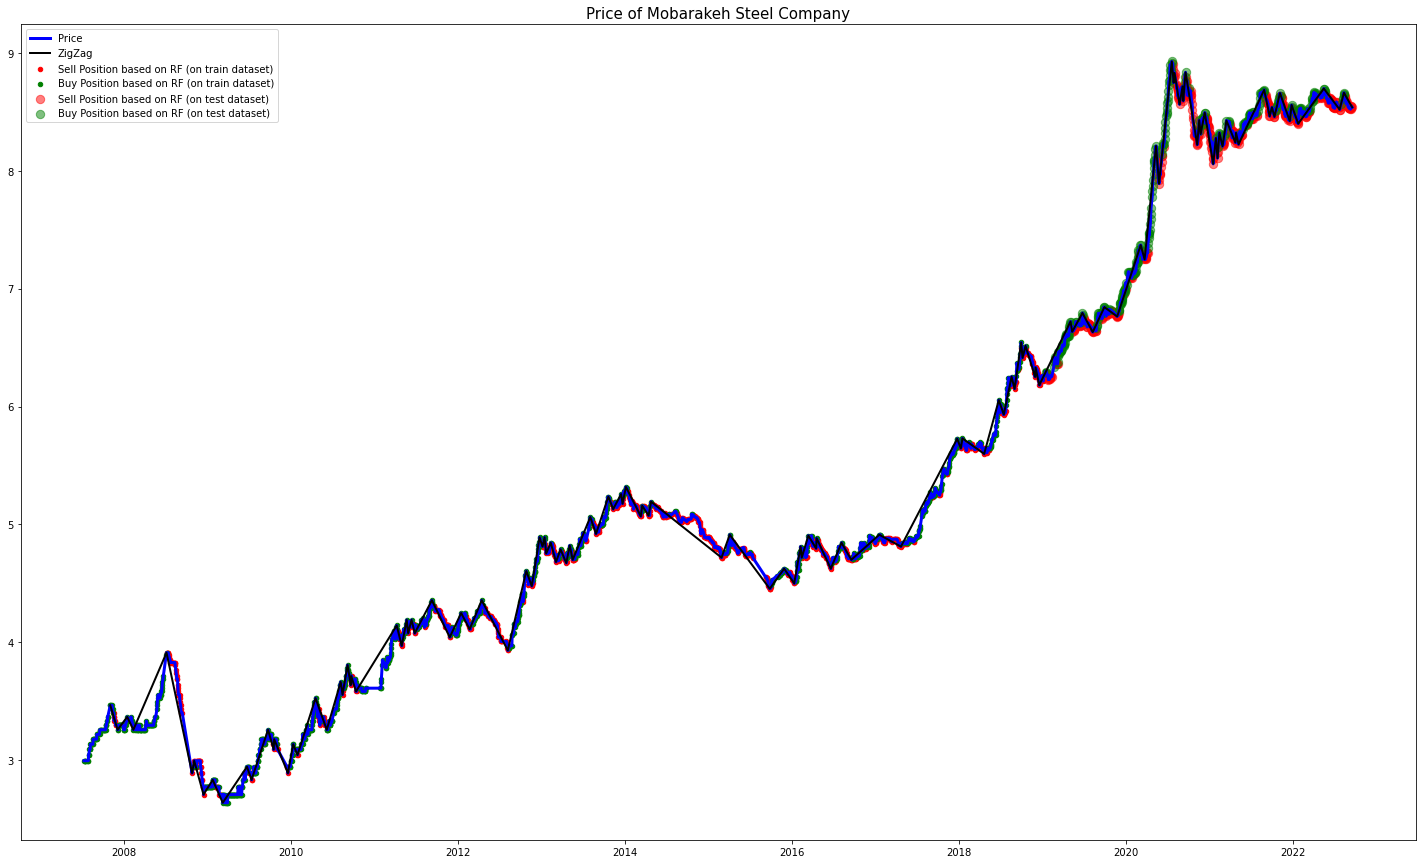

In [ ]:
plt.figure(figsize = (25, 15))

plt.title('Price of Mobarakeh Steel Company', fontsize = 15)
plt.plot(
    foladHist.iloc[-featuresSize:]['date'], 
    np.log(foladHist.iloc[-featuresSize:]['adjClose']),
    color = 'blue',
    lw = 3,
    label = 'Price'
)
plt.plot(
    foladHist.iloc[-featuresSize:]['date'].iloc[(pivots !=0).values.ravel()[-featuresSize:]], 
    np.log(foladHist.iloc[-featuresSize:]['adjClose']).iloc[(pivots !=0).values.ravel()[-featuresSize:]],
    color = 'black',
    lw = 2,
    label = 'ZigZag'
)

# train
plt.scatter(
    foladHist.iloc[-featuresSize: trainEnd]['date'].iloc[trainPred == -1], 
    (np.log(foladHist.iloc[-featuresSize: trainEnd]['adjClose']).iloc[trainPred == -1]),
    color = 'red',
    s = 20,
    label = 'Sell Position based on RF (on train dataset)'
)
plt.scatter(
    foladHist.iloc[-featuresSize: trainEnd]['date'].iloc[trainPred == 1], 
    (np.log(foladHist.iloc[-featuresSize: trainEnd]['adjClose']).iloc[trainPred == 1]),
    color = 'green',
    s = 20,
    label = 'Buy Position based on RF (on train dataset)'
)

# test
plt.scatter(
    foladHist.iloc[trainEnd:]['date'].iloc[testPred == -1], 
    (np.log(foladHist.iloc[trainEnd:]['adjClose']).iloc[testPred == -1]),
    color = 'red',
    s = 70,
    alpha = 0.5,
    label = 'Sell Position based on RF (on test dataset)'
)
plt.scatter(
    foladHist.iloc[trainEnd:]['date'].iloc[testPred == 1], 
    (np.log(foladHist.iloc[trainEnd:]['adjClose']).iloc[testPred == 1]),
    color = 'green',
    s = 70,
    alpha = 0.5,
    label = 'Buy Position based on RF (on test dataset)'
)

plt.legend()